# Search images with deep learning

Images are usually very different if we compare them at pixel level but that's quite different if we look at them after they were processed by a deep learning model. We convert each image into a feature vector extracted from an intermediate layer of the network.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Get a pre-trained model

We choose the model described in paper [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/abs/1704.04861). Pre-trained models are available at [deep-learning-models/releases](https://github.com/fchollet/deep-learning-models/releases/).

In [3]:
from keras.applications.mobilenet import MobileNet
model = MobileNet(input_shape=None, alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=True, 
                  weights='imagenet', input_tensor=None, pooling=None, classes=1000)
model

Using TensorFlow backend.


17227776/17225924 [==============================] - 49s 3us/step


In [4]:
model.name

'mobilenet_1.00_224'

The model is stored here:

In [5]:
import os
os.listdir(os.path.join(os.environ['USERPROFILE'], ".keras", "models"))

['mobilenet_1_0_224_tf.h5']

In [6]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

## Images

We collect images from [pixabay](https://pixabay.com/).

In [7]:
from pyquickhelper.filehelper import unzip_files
if not os.path.exists('simages'):
    os.mkdir('simages')
files = unzip_files("data/dog-cat-pixabay.zip", where_to="simages")
len(files), files[0]

(31, 'simages\\cat-1151519__480.jpg')

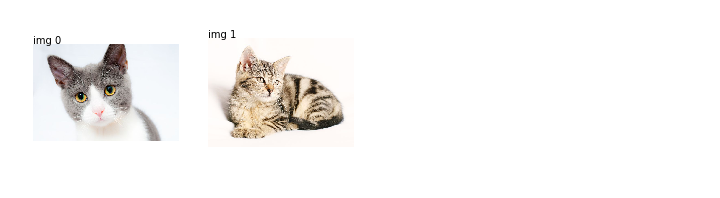

In [8]:
from mlinsights.plotting import plot_gallery_images            
plot_gallery_images(files[:2]);